In [1]:
import Flux
using Flux.Tracker, Statistics, DelimitedFiles
using Flux.Tracker: Params, gradient, update!
using Flux: gpu, Dense, BatchNorm, relu, Chain, ADAM, RMSProp, Descent, params, throttle, Dropout, @epochs, testmode!
using NNlib, ProgressMeter,Plots,ProgressMeter
pyplot()

Plots.PyPlotBackend()

# The problem

$y$ depends on $x1$ and $x2$ via the equation

$y = A + \frac{B}{(x2-C)}$   eq. 1

with $A$, $B$ and $C = f(x1)$ and $f$ unknown. Here we will generate a toy dataset with a simple $f$ and $x1$ with 1 feature, but in reality $f$ is a stronly non-linear function and inputs x1 have multiple features.

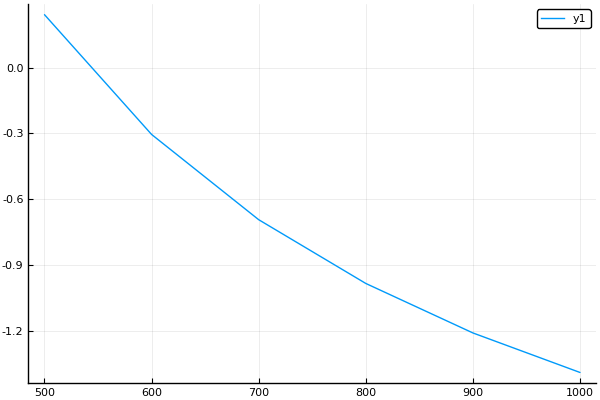

In [10]:
function model(x2,A,B,C) # this is eq. 1
    return A .+ B./(x2.-C)
end

# here we assume we know how A, B and C vary with x1
function fake_eq0(x1)
    A = -3.0 # constant
    B = 40000.0.*0.1.*x1
    C = abs.(10.0 .- x1.*9.0)
    return A, B, C
end

x1 = collect(0.4:0.1:0.8)
x2 = collect(500.:100.:1000.)


A_fake, B_fake, C_fake = fake_eq0(x1)

# we buyild our training set
X1_training = []
X2_training = []
y_training = []

for i =1:length(B_fake)
    append!(X1_training,ones(length(x2),1)*x1[i])
    append!(X2_training,x2)
    append!(y_training,model(x2,A_fake,B_fake[i],C_fake[i]))
end

X1_training=reshape(X1_training,1,length(X1_training))
X2_training=reshape(X2_training,1,length(X2_training))
y_training=reshape(y_training,1,length(y_training))

plot(x2,y_training[X1_training.==0.4]) # for one x1, we have a nice variation described by eq.1

# Solving the problem: 

Combine neural net to predict A, B and C and then use this in eq .1

In [11]:
# B and C should be strictly possitive, so we use the trick of Bishop to take the exp. of the output.
function B_(x,network)
    return reshape(exp.(network(x)[2,:]),1,size(x,2))
end

function C_(x,network)
    return reshape(exp.(network(x)[3,:]),1,size(x,2))
end

function A_(x,network)
    return reshape((network(x)[1,:]),1,size(x,2))
end

function predictions(x,x2,network)
    return model(x2,A_(x,network),B_(x,network),C_(x,network))
end

# Loss function
function loss(x,x2,y,network)
    return Flux.mse(predictions(x,x2,network),y)
end

# We need this to init the bias of the output layer not too far from the y values
function init_f(dims)
    return ones(dims).*[-4.;log.(1000.);log.(10.)]
end

# Constructing the network
nb_neurons = 100
c1 = Flux.Dense(1, nb_neurons, relu)
c2 = Flux.Dense(nb_neurons, nb_neurons, relu)
cout= Flux.Dense(nb_neurons,3,initb=init_f)
core = Flux.Chain(c1,c2,cout)


Chain(Dense(1, 100, NNlib.relu), Dense(100, 100, NNlib.relu), Dense(100, 3))

In [12]:
# we check the loss works
loss(X1_training, X2_training, y_training,core)

9.32735638819756 (tracked)

In [13]:
# loop details
nb_epoch = 1000

record_loss_train = []
evalcb = () -> (push!(record_loss_train, loss(X1_training, X2_training, y_training,core).data))

p = ProgressMeter.Progress(nb_epoch, 1)
for i = 1:nb_epoch
    Flux.train!(loss, params(core), [(X1_training, X2_training, y_training,core)], ADAM(0.001), cb = throttle(evalcb, 1))
    ProgressMeter.update!(p, i)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:28


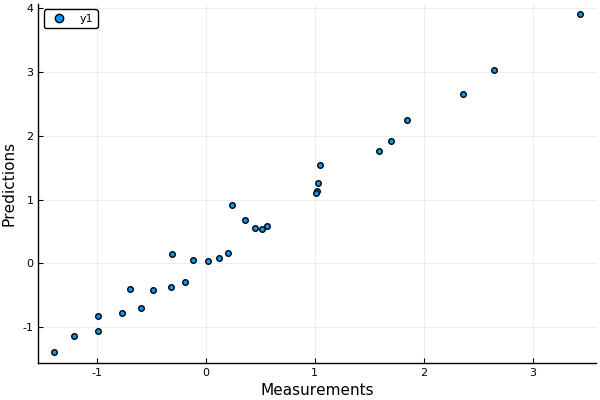

In [14]:
y_preds = predictions(X1_training,X2_training,core).data

scatter(y_training',y_preds',xlabel="Measurements", ylabel="Predictions")